<a href="https://colab.research.google.com/github/alifele/Brain_Computer_Interface-Competition-/blob/master/CNN_with_Hilbert_images_The_Master_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EEG_BCI/')
import datafetch
import plotters

## Data Load and Selection

In [0]:
global subj_list 
global selector
subj_list = [0,0,0,0,0,0]

In [0]:
def update_subjlist(sector):

  if sector ==1:
    subj_1 = datafetch.fetch_subject(1)
    subj_2 = datafetch.fetch_subject(2)
    subj_3 = datafetch.fetch_subject(3)
    subj_4 = datafetch.fetch_subject(4)
    subj_5 = datafetch.fetch_subject(5)
    return np.array([subj_1, subj_2, subj_3, subj_4, subj_5, 1])


  if sector ==2:
    subj_6 = datafetch.fetch_subject(6)
    subj_7 = datafetch.fetch_subject(7)
    subj_8 = datafetch.fetch_subject(8)
    subj_9 = datafetch.fetch_subject(9)
    subj_10 = datafetch.fetch_subject(10)

    return np.array([0,0,0,0,0] + [subj_6, subj_7, subj_8, subj_9, subj_10, 2])


  if sector ==3:
    subj_11 = datafetch.fetch_subject(11)
    subj_12 = datafetch.fetch_subject(12)
    subj_13 = datafetch.fetch_subject(13)
    subj_14 = datafetch.fetch_subject(14)
    subj_15 = datafetch.fetch_subject(15)

    return np.array([0,0,0,0,0] + [0,0,0,0,0] + [subj_11, subj_12, subj_13, subj_14, subj_15, 3])

In [0]:
## To load other sectors, you just need to simpy change the following list
## and then change the arguments of the selector design function (which are set 
## to the default values for subject 1,2,3,4,5). you just need to change the subjects
## to for example [6,10] if you want to load the subjcets number 6,7,8,9,10.
## IMPORTANT NOTE:  note that first of all, you need to uncommand the sector 
## that you want to laod its data

#subj_list = update_subjlist(1)

In [0]:
def selector_desing(sector, classes=[1,4], trail=[0,24]):
  selector = []
  for i in range((sector-1)*5+1, sector*5+1):
    for j in range(classes[0],classes[1]+1):
      for k in range(0,trail[1]+1):
        selector.append((i,j,k))
  selector = np.array(selector)
  np.random.shuffle(selector)

  return selector

In [44]:
selector = selector_desing(1, [1,4], [0,24])
selector.shape, selector

((500, 3), array([[ 1,  2, 16],
        [ 1,  2,  8],
        [ 5,  4, 20],
        ...,
        [ 3,  4,  6],
        [ 4,  3, 12],
        [ 2,  2,  2]]))

In [0]:
subj_list = update_subjlist(1)

In [0]:
def select_data(select):
  '''
  it selects the data according the the selector.
  for exmaple if the seclevto os equal to (3,4,1) the
  data of subject number 1, which belongs to the class number 4, and its 1 trail 
  will be selected. which is a 7200 data point with 63 channels
  '''
  global subj_list

  return subj_list[select[0]-1]['train_data_class{}'.format(select[1])][select[2]]


In [46]:
selector[12]

array([ 1,  1, 18])

In [47]:
test = select_data(selector[12])
test.shape

TypeError: ignored

## *Hilbert Images*

In [0]:
from plotters import Hilbert_concat, Hilbert_generator, data_to_HilbertMat

In [0]:
x,y = Hilbert_generator()
x,y = Hilbert_concat(x,y)

In [0]:
def item_to_Hilbert(item):

  global selector
  global subj_list
  
  '''
  function will get item (the index of the patient) and will return the hilbert 
  images that each channel of eeg will be different channels of the retured image

  This fuction will also return the label. for example the label 1 indicates that
  the patient belongs to the class number 1
  '''
  mat = data_to_HilbertMat(x,y, select_data(selector[item])[:,0], double_factor=2)
  mat = np.expand_dims(mat, axis=2)
  mats = mat
  label = selector[item][1]
  for i in range(1,63):
    mat = data_to_HilbertMat(x,y, select_data(selector[item])[:,i], double_factor=2)
    mat = np.expand_dims(mat, axis=2)
    mats = np.concatenate((mats, mat), axis=2)

  return mats, label

In [0]:
image1, label  = item_to_Hilbert(12)

In [67]:
image1.shape, label

((64, 128, 63), 4)

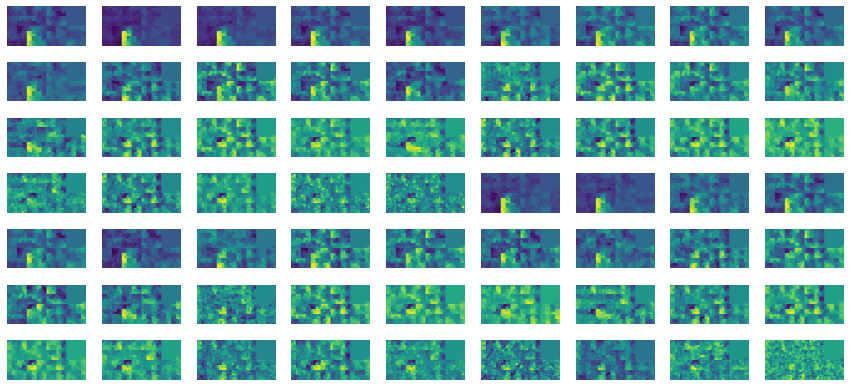

In [68]:
fig = plt.figure(figsize=(15,7))
for i in range(63):
  ax = fig.add_subplot(7,9,i+1)
  ax.imshow(image1[:,:,i])
  ax.axis('off')

In [0]:
def load_hilbert_batch(n=[0,30],sector=1):
  global subj_list
  global selector

  labels = []

  Data = []
  if sector != subj_list[-1]:
    subj_list = update_subjlist(sector)
    selector = selector_desing(sector)

  data, label = item_to_Hilbert(n[0])
  Data.append(data)
  labels.append(label)
  for i in range(n[0]+1, n[1]):
    data, label  = item_to_Hilbert(i)
    labels.append(label)
    Data.append(data)

  return np.array(Data), np.array(labels)

In [70]:
data, label = load_hilbert_batch(n=[0,20], sector=3)
data.shape, label

((20, 64, 128, 63),
 array([1, 2, 2, 3, 2, 1, 1, 2, 1, 2, 2, 2, 3, 1, 3, 2, 1, 3, 4, 1]))

### So...

So up until now, You can load the data as hilbert images in which the different channels of the eeg are as the different channels of the loaded image

# Training the model

In [0]:
#! python3 -m pip install --upgrade tensorflow

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D( 8, 7, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.MaxPool2D(2))

model.add(keras.layers.Conv2D( 32, 5, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.Conv2D( 32, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D( 64, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.Conv2D( 64, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D( 128, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.Conv2D( 128, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D( 256, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.Conv2D( 256, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Conv2D( 256, 3, padding ='same', activation='relu', input_shape = [64,128,63]))
model.add(keras.layers.MaxPool2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(4, activation='softmax'))



In [74]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 64, 128, 8)        24704     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 64, 8)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 64, 32)        6432      
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 32, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 32, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 32, 64)       

In [0]:
opt = keras.optimizers.SGD(lr=0.004)
model.compile(optimizer=opt,
              loss = ['sparse_categorical_crossentropy'],
              metrics = ['accuracy'])

In [0]:
Sectors = [1,2,3]
intervals = [[25*i,25*(i+1)] for i in range(20)]
for epoch in range(3):
  for sec in Sectors:
    for interval in intervals:
      data, label = load_hilbert_batch(interval, sec)
      model.fit(data, label-1, epochs=15)
      print('############################')
      print('############################')
      print('sector:{}    and    interval:{}    and    epoch:{}'.format(sec, interval, epoch))
      print('############################')
      print('############################')

Train on 25 samples
Epoch 1/15
25/25 [==============================] - 0s 14ms/sample - loss: 5.4659 - acc: 0.2800
Epoch 2/15
25/25 [==============================] - 0s 2ms/sample - loss: 6.3425 - acc: 0.0800
Epoch 3/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.5291 - acc: 0.4000
Epoch 4/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.5250 - acc: 0.2400
Epoch 5/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.4483 - acc: 0.2000
Epoch 6/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.3532 - acc: 0.2800
Epoch 7/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.4899 - acc: 0.3600
Epoch 8/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.4019 - acc: 0.2800
Epoch 9/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.5465 - acc: 0.1600
Epoch 10/15
25/25 [==============================] - 0s 2ms/sample - loss: 1.4443 - acc: 0.2800
Epoch 11/15
25/25 [=========

(20,)

array([2, 4, 1, 4, 2, 3, 2, 1, 2, 3, 2, 4, 1, 1, 1, 3, 2, 1, 3, 4])

#Trash


In [29]:
subj_list[-1]

3

In [0]:
a = ['a{}'.format(i) for i in range(10)]

In [0]:
a[1] = 2

In [0]:
x='buffalo'    
exec("%s = %d" % (x,2))

In [33]:
buffalo

2

In [0]:
a1 = np.random.random((3,3))
a1 =np.expand_dims(a1, axis=2)

In [0]:
a2 = np.random.random((3,3))
a2 = np.expand_dims(a2, axis=2)

In [36]:
a1.shape , a2.shape

((3, 3, 1), (3, 3, 1))

In [0]:
a = [a1,a2]

In [38]:
a = np.concatenate((a,a2), axis=2)

ValueError: ignored

In [0]:
a.shape

In [47]:
intervals = [[25*i,25*(i+1)] for i in range(20)]
intervals

[[0, 25],
 [25, 50],
 [50, 75],
 [75, 100],
 [100, 125],
 [125, 150],
 [150, 175],
 [175, 200],
 [200, 225],
 [225, 250],
 [250, 275],
 [275, 300],
 [300, 325],
 [325, 350],
 [350, 375],
 [375, 400],
 [400, 425],
 [425, 450],
 [450, 475],
 [475, 500]]

In [0]:
def test():
  global a
  a =  a+12



In [0]:
test()


In [0]:
a

In [0]:
'b' in globals()